# PRÁCTICA 2: AUTOENCODERS Y PRECISIÓN MIXTA

En esta práctica vamos a aprender a definir una red neuronal desde cero con el objetivo de clasificar un conjunto de imágenes. Para ello, usaremos una arquitectura muy conocida llamada **_Autoencoder_**.

El objetivo de esta arquitectura consiste en codificar un conjunto de datos hacia una determinada representación a la que denominamos **_espacio latente_** usando una red neuronal. Posteriormente, este espacio codificado es decodificado por una segunda red nueronal para recuperar los datos de entrada. Una vez entrenada la red, el espacio latente puede ser visualizado para dar evaluar la capacidad de la red a la hora de diferenciar entre los diferentes tipos de imágenes con las que fue entrenada.

En primer lugar, importaremos todas las librerías necesarias para definir nuestro autoencoder.

In [45]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [46]:
import os
import random

# Librerías de PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Torch summary para hacer comprobacionesde la red
from torchsummary import summary

# Torch vision para descargar y preprocesar el conjunto de datos que usaremos para entrenar la red
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

# Herramientas adicionales para la visualización de los datos y resultados
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

En segundo lugar haremos una serie de comprobaciones para determinar si podemos usar o no una GPU para entrenar la red. El uso de GPU en entrenamiento es altamente recomendable por no decir necesario para que los tiempos de ejecución sean asumibles.

También aprovecharemos para definir una serie de parámetros de configuración para nuestra red:
   - **Batch size**: Por normal general, los conjuntos de datos usados para entrenar una red neuronal tienen un gran tamaño. Esto impide que podamos cargar todos estos datos directamente en nuestra GPU. Por ello, es una práctica común entrear la red en un "subconjunto" de los datos más pequeño, calcular los gradientes y optimizar los parámetros de la red. El tamaño de este subconjunto es conocido como "batch size" y suele estar comprendido entre 8 y 1024 (aumentando generalmente en potencias de 2).
   - **Epochs**: El paso de todas los lotes que componen el conjunto de datos por la red neuronal se conoce como una epoch. Es decir, cuando se completa una epoch la red ha visto el conjunto de datos completo. Generalmente, una sola epoch no es suficiente para entrenar una red neuronal, por lo que se suele recorre el conjunto de datos de entrada varias veces hasta que la red se ha optimizado por completo. El número total de veces que se recorre un dataset/epochs es un parámetro más a definir en nuestra red.
   - **Learning rate**: Cada vez que se calcula el gradiente para un lote, el optimizador se encarga de actualizar los valores de los parámetros de la red a partir de este gradiente. Sin embargo, este gradiente solo nos define la "dirección" de la actualización. La "cantidad" en la que los parámetros se mueven en esa "dirección" viene determinada por el learning rate: cuanto más alto, mayor será la actualización de los parámetros de la red en base a la dirección del gradiente. Un valor alto puede ayudar a optimizar los parámetros más rápido, aunque también puede inducir divergencia. Aunque este valor depende de la red y el optimizador usado, por lo general se suele usar un valor entre 1e<sup>-3</sup> y 1e<sup>-5</sup>.

In [47]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("El proyecto se ejecutará en: ", DEVICE)

config = {
    "batch_size": 64,
    "epochs": 3,
    "lr": 1e-4,   # learning rate
}

El proyecto se ejecutará en:  cuda


Una vez terminada esta configuración preliminar, vamos a descargar los datos que usaremos para entrenar la red neuronal. El conjunto que usaremos se conoce como `FashionMNIST` y consiste de un conjunto de imágenes de diferentes prendas de ropa. Además, cada imagen contiene un identificador que determine el tipo de prenda de la images (por ejemplo, camiseta, zapatillas...)

Antes de descargar los datos, definiremos una función para convertir las imágenes originales (PIL arrays) a Tensores.

In [48]:
def collate_fn(batch):
    process = transforms.Compose([
                transforms.ToTensor(),
                transforms.Pad([2])]
                )

    # x - imágenes; procesamos cada imagen en el lote
    x = [process(data[0]) for data in batch]
    x = torch.concat(x).unsqueeze(1)

    # y - labels, hay que convertirlos al tipo LongTensor
    y = torch.LongTensor([data[1] for data in batch])

    return x, y

A continuación se descargan los datos:

In [49]:
labels = ["Camiseta",
          "Vaqueros",
          "Jersey",
          "Vestido",
          "Abrigo",
          "Sandalia",
          "Falda",
          "Deportiva",
          "Bolso",
          "Zapato"]

# Descarga de los datos
train_data = FashionMNIST("./MNIST_DATA", train=True, download=True)
valid_data = FashionMNIST("./MNIST_DATA", train=False, download=True)

# Generamos los DataLoader
train_loader = DataLoader(train_data, batch_size=config["batch_size"],
                          shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=config["batch_size"],
                           shuffle=False, collate_fn=collate_fn)

Al comienzo, definimos los identificadores para cada una de las imágenes.

Posteriomente descargamos el conjunto de entrenamiento y validación:
   - **Conjunto de entrenamiento**: Compuesto por las imágenes que usaremos para entrenar y actualizar los parámetros de la red
   - **Conjunto de validación**: Cada un número determinado de epochs, evaluremos este conjunto con la red para obtener una predicción. Esta predicción **NO SE USARÁ PARA ENTRENAR LA RED**. El objetivo es evaluar si las predicciones son las correctas para determinar si la red neuronal tiene capacidad de generalización o está aprendiendo a memorizar los datos de entrenamiento

Una vez hemos descargado los datos, podemos hacer una comprobación rápida para inspeccionar las imágenes:


Inspección de los datos de entrenamiento: 
Tamaño del lote:  torch.Size([64, 1, 32, 32])


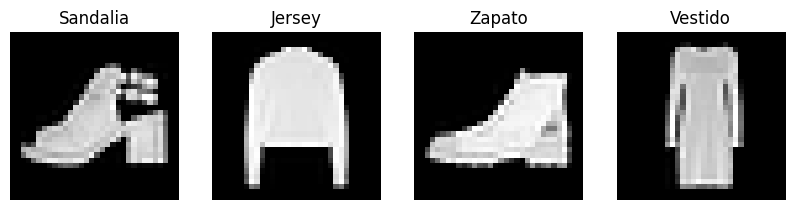

In [50]:
print("Inspección de los datos de entrenamiento: ")
for _, data in enumerate(train_loader):
    print("Tamaño del lote: ", data[0].shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))

    for i in range(4):
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(labels[data[1][i]])
    plt.show()
    # Usamos break para no recorrer todo el DataLoader
    break

Ha llegado el momento de definir nuestra red neuronal de codificación y decodificación. En primer lugar, definiremos una seria de atributos que serán de utilidad para definir las capas de nuestras redes:

In [51]:
# Model parameters:
LAYERS = 3  # Cantidad de capas en la red
KERNELS = [3, 3, 3]  # Tamaño del kernel de convolución (uno para cada capa)
CHANNELS = [32, 64, 128]  # Cantidad de canales/filtros que se calcularán en cada capa
STRIDES = [2, 2, 2]  # Parámetro que determina el movimiento del filtro a través de los datos de entrada. Al realizar una operación de convolución, este parámetros determina cuántas unidades se desplaza el filtro en cada paso. Este desplazamiento puede ser horizontal, vertical o ambos, según su configuración.
LINEAR_DIM = 2048  # Tamaño de las capas densas (el número de neuronas de cada capa densa)

Ahora definimos la red de codificación:

In [52]:
# Siempre que definimos una red, creamos una clase que hereda de nn.Module
class Encoder(nn.Module):

    def __init__(self, output_dim=2, use_batchnorm=False, use_dropout=False):
        super(Encoder, self).__init__()

        # Dimensión del espacio codificado (espacio latente)
        self.output_dim = output_dim

        # Variables que determinan si se usan capas de dropout y de normalización de lotes
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        # Hyperparámetros de las capas convolucionales
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS
        self.strides = STRIDES
        self.conv = self.get_convs()  # Esta función define las capas como un modelo secuencial (es opcional, pero ayuda a organizar el código)

        # Capas densas para generar el espacio latente
        self.fc_dim = LINEAR_DIM
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(self.fc_dim, self.output_dim)


    def get_convs(self):
        """
        generating convolutional layers based on model's
        hyper parameters
        """
        conv_layers = nn.Sequential()  # Definimos un modelo secuencial (cada capa se ejecuta una detrás de otra)
        for i in range(self.layers):
            if i == 0: conv_layers.append(nn.Conv2d(1,  # Número de canales de la imagen de entrada (1 si es imagen en escala de grises, 3 si es RGB)
                                              self.channels[i],  # Número de filtros que genera esta capa en la salida
                                              kernel_size=self.kernels[i],
                                              stride=self.strides[i],
                                              padding=1)
                                         )

            else: conv_layers.append(nn.Conv2d(self.channels[i-1],
                                         self.channels[i],
                                         kernel_size=self.kernels[i],
                                         stride=self.strides[i],
                                         padding=1))

            if self.use_batchnorm:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            # Here we use ReLU as activation function
            conv_layers.append(nn.ReLU())

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers


    # Este método es obligatorio y se usa para determinar el flujo de ejecución de la red neuronal
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.linear(x)

summary(Encoder().to(DEVICE), input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                    [-1, 2]           4,098
Total params: 96,770
Trainable params: 96,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.37
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


A continuación definimos la red de decodificación, que es un espejo de la red de codificación (aunque no es obligatorio):

In [53]:
class Decoder(nn.Module):

    def __init__(self, input_dim=2, use_batchnorm=False, use_dropout=False):

        super(Decoder, self).__init__()

        # Variables que determinan si se usan capas de dropout y de normalización de lotes
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.fc_dim = LINEAR_DIM
        self.input_dim = input_dim

        # Hyperparámetros de las capas convolucionales
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS[::-1] # flip the channel dimensions
        self.strides = STRIDES

        # Al ser un espejo de la red de codificación, primero usaremos capas densas y luego convolucionales transpuestas
        self.linear = nn.Linear(self.input_dim, self.fc_dim)
        self.conv =  self.get_convs()

        self.output = nn.Conv2d(self.channels[-1], 1, kernel_size=1, stride=1)

    def get_convs(self):
        conv_layers = nn.Sequential()
        for i in range(self.layers):

            if i == 0: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1)
                            )

            else: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i-1],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1
                                              )
                            )

            if self.use_batchnorm and i != self.layers - 1:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            conv_layers.append(nn.ReLU())

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers


    def forward(self, x):
        x = self.linear(x)
        # reshape 3D tensor to 4D tensor
        x = x.reshape(x.shape[0], 128, 4, 4)
        x = self.conv(x)
        return self.output(x)

summary(Decoder().to(DEVICE), input_size=(2, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]           6,144
   ConvTranspose2d-2            [-1, 128, 8, 8]         147,584
              ReLU-3            [-1, 128, 8, 8]               0
   ConvTranspose2d-4           [-1, 64, 16, 16]          73,792
              ReLU-5           [-1, 64, 16, 16]               0
   ConvTranspose2d-6           [-1, 32, 32, 32]          18,464
              ReLU-7           [-1, 32, 32, 32]               0
            Conv2d-8            [-1, 1, 32, 32]              33
Total params: 246,017
Trainable params: 246,017
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.90
Params size (MB): 0.94
Estimated Total Size (MB): 1.84
----------------------------------------------------------------


Una vez hemos definido las dos redes neuronales, es conveniente hacer una nueva red neuronal que aune las dos anteriores. Esta nueva red será nuestro **_autoencoder_** y simplificará enormemente su uso más adelante:

In [54]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(output_dim=2,
                               use_batchnorm=True, use_dropout=False)
        self.decoder = Decoder(input_dim=2,
                               use_batchnorm=True, use_dropout=False)

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = AutoEncoder()
model.to(DEVICE)

AutoEncoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=2048, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear): Linear(in_features=2, out_features=2048, bias=True)
    (conv): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-

Una vez definido nuestro autoencoder, podemos empezar a escribir nuestro loop de entrenamiento. Sin embargo, antes de hablar sobre el entrenamiento, vamos a definir una serie de funciones para representar el espacio latente codificado a medida que entrenamos, para así poder comprender como la red neuronal aprende de manera progresiva a clasificar nuestro datos:

In [55]:
def plotting(step:int=0, show=False):

    model.eval()  # Pasamos el modelo a modo evaluación (en este modo, las capas de Dropout y BatchNorm se desactivan para mejorar la precisión de las predicciones)

    points = []
    label_idcs = []

    path = "./ScatterPlots"
    if not os.path.exists(path): os.mkdir(path)

    for i, data in enumerate(valid_loader):
        img, label = [d.to(DEVICE) for d in data]
        # Solo necesitamos codificar las imágenes
        proj = model.encoder(img)
        points.extend(proj.detach().cpu().numpy())
        label_idcs.extend(label.detach().cpu().numpy())
        del img, label

    points = np.array(points)

    # Creamos nuestra gráfica
    fig, ax = plt.subplots(figsize=(10, 10) if not show else (8, 8))
    scatter = ax.scatter(x=points[:, 0], y=points[:, 1], s=5.0,
                c=label_idcs, cmap='tab10', alpha=0.9, zorder=2)
    plt.title("Step {}".format(step))
    handles, _ = scatter.legend_elements()
    plt.legend(handles=handles, labels=labels)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])

    if show:
        ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
        plt.show()
    else:
        # Aqui guardamos la gráfica actual
        plt.savefig(f"{path}/Step_{step:03d}.png", bbox_inches="tight")
        plt.close() # Es importante no olvidarse de cerrar la figura para que no se quede cargada en memoria
        model.train()

# Conversión de las gráficas a un formato GIF
def save_gif():

  frames = []
  imgs = sorted(os.listdir("./ScatterPlots"))

  for im in imgs:
      new_frame = Image.open("./ScatterPlots/" + im)
      frames.append(new_frame)

  frames[0].save("latentspace.gif", format="GIF",
                 append_images=frames[1:],
                 save_all=True,
                 duration=200, loop=0)

Antes de definir el loop de entrenamiento, vamos a definir unas variables de configuración y el optimizador para poder usarlas durante el entrenamiento:

In [56]:
criterion = nn.MSELoss()  # Usaremos como función de péridida el error cuadrático medio
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-5)

# For mixed precision training
scaler = torch.amp.GradScaler("cuda")  # Para poder hacer mixed precision training (explicación en la siguiente celda)
steps = 0  # Variable para contar el número de steps/lotes que ha ido viendo la red

### UN POCO DE TEORÍA SOBRE EL ENTRENAMIENTO CON MEZCLA DE PRECISIÓN

Como se puede ver en la celda anterior, hemos definido una variable llamada "scaler". Esta variable nos permitirá hacer un entrenamiento con mezcla de precisión.

Durante el entrenamiento estándar de redes neuronales, se utiliza `Float32` para representar los parámetros del modelo, a costa de un mayor requerimiento de memoria. En el entrenamiento de precisión mixta, se utiliza ``Float16`` para almacenar los pesos, las activaciones y los gradientes durante las iteraciones de entrenamiento.

Sin embargo, como vimos anteriormente, esto crea un problema, ya que el rango de valores que puede almacenar ``Float16`` es menor que el de ``Float32``, y la precisión disminuye a medida que el número se reduce. Esto se traduce en una disminución de la precisión del modelo, en consonancia con la precisión de los valores de punto flotante calculados.

Para evitar esto, se almacena una copia maestra de los pesos en ``Float32``. Esta se convierte a ``Float16`` durante parte de cada iteración de entrenamiento (un pase hacia adelante, backpropagation y actualización de pesos). Al final de la iteración, los gradientes de pesos se utilizan para actualizar los pesos maestros durante el paso del optimizador.

Aquí, podemos observar la ventaja de conservar la copia ``Float32`` de los pesos. Dado que la tasa de aprendizaje suele ser baja, al multiplicarlos por los gradientes, estos pueden ser valores minúsculos. Para Float16, cualquier número con una magnitud menor a 2<sup>-24</sup> se equiparará a cero, ya que no se puede representar (este es el límite desnormalizado para ``Float16``). Por lo tanto, al completar las actualizaciones en ``Float32``, estos valores de actualización se pueden conservar.

Por lo anterior, es conveniente hacer una escalado de la función de pérdidas, un proceso mediante el cual el valor de la pérdida se multiplica por un factor de escala después de completar el paso hacia adelante y antes de la backprogation. La regla de la cadena dicta que todos los gradientes se escalan posteriormente por el mismo factor, lo que los mantiene dentro del rango de ``Float16``.

Una vez calculados los gradientes, se pueden dividir por el mismo factor de escala, antes de usarlos para actualizar los pesos maestros en ``Float32``, como se describe en la sección anterior.

El uso de ``Float16`` y ``Float32`` es la razón por la que esta técnica se denomina entrenamiento de precisión mixta.



A continuación vamos a deifinir el loop de entraniento. Para tener el código más ordenado, definiremos dos funciones:
   - **Función "train"**: Contiene toda la lógica necesaria para entrenar el modelo durante una epoch completa
   - **Función "validate"**: Contiene toda la lógica para evaluar el módelo en un conjunto de datos (pero sin actualizar los parámetros de la red con estos datos)

In [57]:
def train(model, dataloader, criterion, optimizer, save_distrib=False):
    # Esta variable solo la usamos para hacer un seguimiento del entranamiento y poder guardar los espacios latentes
    global steps

    model.train()
    train_loss = 0.0

    # Barra de progreso
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Train")

    for i, batch in enumerate(dataloader):

        optimizer.zero_grad()
        x = batch[0].to(DEVICE)

        # Aquí implementamos el entrenamiento con mezcla de precisión
        with torch.amp.autocast("cuda"):
            y_recons = model(x)
            loss = criterion(y_recons, x)

        train_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_bar.set_postfix(
            loss=f"{train_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        batch_bar.update()

        # Guardamos el estado del espacio latente para su posterior visualización
        if steps % 10 == 0 and save_distrib and steps <= 400: plotting(steps)
        steps += 1

        # Eliminamos el cache no necesario de la GPU para ahorrar memoriar
        torch.cuda.empty_cache()
        del x, y_recons

    batch_bar.close()
    train_loss /= len(dataloader)

    return train_loss


def validate(model, dataloader, criterion):

    model.eval()  # Usamos el modelo en modo evaluación (capas de Dropout y BatchNorm desactivadas)
    valid_loss = 0.0

    # Barra de progreso
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Validation")

    for i, batch in enumerate(dataloader):
        x = batch[0].to(DEVICE)

        with torch.no_grad():  # No necesitamos los gradientes en la validación
            y_recons = model(x)
            loss = criterion(y_recons, x)

        valid_loss += loss.item()

        batch_bar.set_postfix(
            loss=f"{valid_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        batch_bar.update()

        torch.cuda.empty_cache()
        del x, y_recons

    batch_bar.close()
    valid_loss /= len(dataloader)

    return valid_loss

A continuación definimos el loop de entrenamiento y entrenamos nuestra red neuronal:

In [58]:
for i in range(config["epochs"]):

    curr_lr = float(optimizer.param_groups[0]["lr"])
    train_loss = train(model, train_loader, criterion,
                       optimizer, save_distrib=True)
    valid_loss = validate(model, valid_loader, criterion)

    print(f"Epoch {i+1}/{config['epochs']}\nTrain loss: {train_loss:.4f}\t Validation loss: {valid_loss:.4f}\tlr: {curr_lr:.4f}")

Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/3
Train loss: 0.0307	 Validation loss: 0.0256	lr: 0.0001


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/3
Train loss: 0.0254	 Validation loss: 0.0247	lr: 0.0001


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/3
Train loss: 0.0244	 Validation loss: 0.0241	lr: 0.0001


Una vez terminado el entrenamiento, podemos visualizar el proceso de optimización del espacio latente:

In [59]:
save_gif()

<img src="latentspace.gif" width=500, heigh=500 />

<img src="ScatterPlots/Step_400.png" width=500, heigh=500 />

Por último, podemos seleccionar puntos aleatorios del espacio latente anterior y aprovechar la red de decodificación para comprobar que la red neuronal ha aprendedido correctamente a recuperar los datos de entrada a partir del espacio codificado:

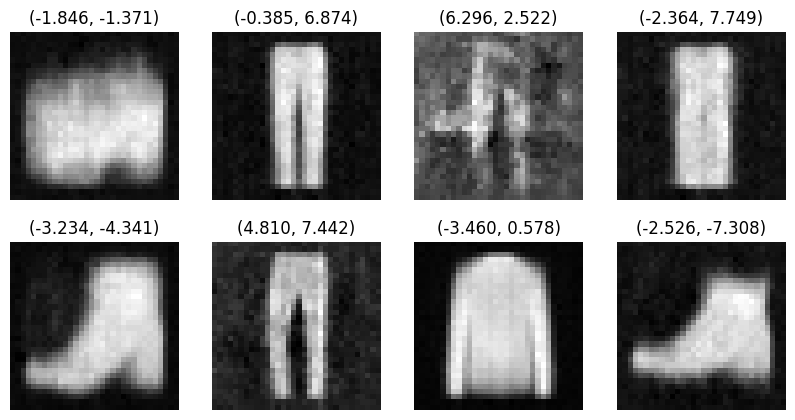

In [60]:
# Muestras aleatorias de puntos en el espacio codificado
xs = [random.uniform(-6.0, 8.0) for i in range(8)]
ys = [random.uniform(-7.5, 10.0) for i in range(8)]

points = list(zip(xs, ys))
coords = torch.tensor(points).unsqueeze(1).to(DEVICE)

nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))

model.eval()
with torch.no_grad():
    generates = [model.decoder(coord) for coord in coords]

# Muestra las imágenes decodificadas a partir de los puntos anteriores
idx = 0
for row in range(0, nrows):
    for col in range(0, ncols):
        ax = axes[row, col]
        im = generates[idx].squeeze().detach().cpu()
        ax.imshow(im, cmap="gray")
        ax.axis("off")
        coord = coords[idx].detach().cpu().numpy()[0]
        ax.set_title(f"({coord[0]:.3f}, {coord[1]:.3f})")
        idx += 1

plt.show()